In [36]:
from tensorflow.python.client import device_lib

print(tf.test.gpu_device_name())

In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
categories = ["angry",
              "disgust",
              "fear",
              "happy",
              "neutral",
              "sad",
              "surprise"]

In [3]:
root = "./FER_data/images"

for data in os.listdir(root):
  path = os.path.join(root,data)
  print("\n\n")
  print(f"No. of samples of each class in {data} data", end = "\n\n")
  for folder in os.listdir(path):
    n = len(os.listdir(os.path.join(path, folder)))
    print(f"no. of samples of class {folder} are {n}")




No. of samples of each class in test data

no. of samples of class angry are 623
no. of samples of class disgust are 94
no. of samples of class fear are 820
no. of samples of class happy are 1140
no. of samples of class neutral are 910
no. of samples of class sad are 930
no. of samples of class surprise are 860



No. of samples of each class in train data

no. of samples of class angry are 3370
no. of samples of class disgust are 342
no. of samples of class fear are 3283
no. of samples of class happy are 6024
no. of samples of class neutral are 4072
no. of samples of class sad are 4008
no. of samples of class surprise are 2345



No. of samples of each class in validation data

no. of samples of class angry are 960
no. of samples of class disgust are 111
no. of samples of class fear are 1018
no. of samples of class happy are 1825
no. of samples of class neutral are 1216
no. of samples of class sad are 1139
no. of samples of class surprise are 797


In [38]:
# preparing train, val, and test datasets along with data augmentation

In [4]:

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=25,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            rescale=1./255)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          rescale=1./255)



train_data = train_gen.flow_from_directory(os.path.join(root,"train"),
                                           batch_size=32,
                                           target_size=(48,48),
                                           class_mode='categorical',
                                           shuffle=True)

val_data = val_gen.flow_from_directory(os.path.join(root,"validation"),
                                           batch_size=32,
                                           target_size=(48,48),
                                           class_mode='categorical',
                                           shuffle=True)


test_data = tf.keras.utils.image_dataset_from_directory(os.path.join(root,"test"),
                                                       batch_size=32,
                                                       label_mode='categorical',
                                                       shuffle=False,
                                                       image_size=(48,48))


Found 23444 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 5377 files belonging to 7 classes.


In [39]:
# Visualizing Train data with data augmentation

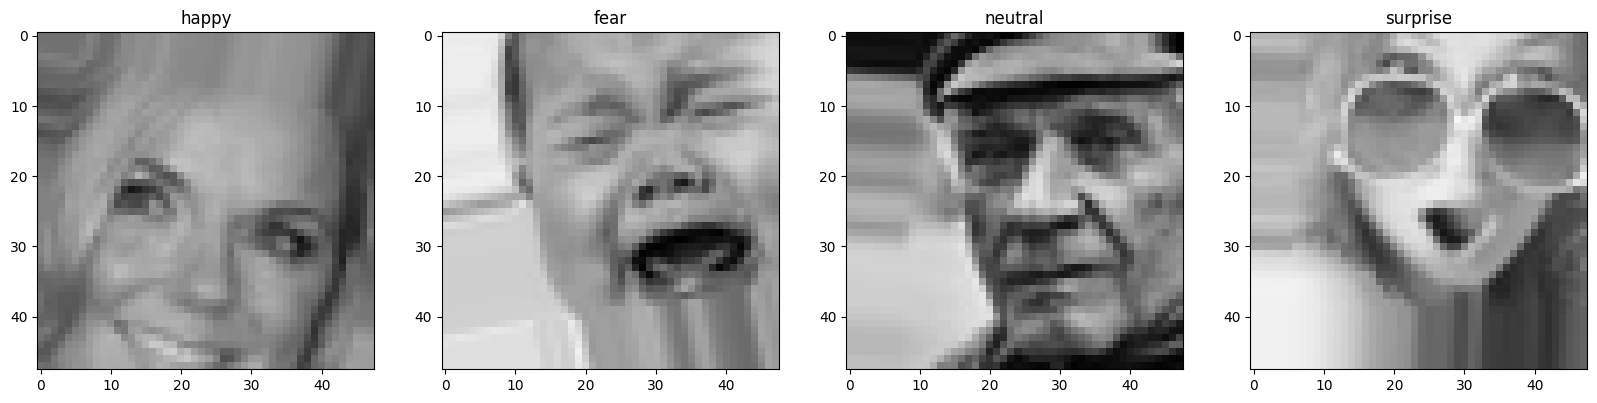

In [5]:
batch = iter(train_data).next()
fig, ax = plt.subplots(nrows = 1,ncols = 4, figsize = (20,20))
for id, img in enumerate(batch[0][:4]):
  i = np.argmax(batch[1][id])
  ax[id].imshow(img)
  ax[id].title.set_text(categories[i])
    

In [40]:
# Creating test_x and test_y numpy arrays from test_data

In [14]:
test_x = np.array([]).reshape((0,48,48,3))
test_y = np.array([]).reshape(0,)

for x, y in test_data:
  # y = tf.reshape(y, shape=[len(y)])
  label = tf.argmax(y,axis=1)
  test_y = np.concatenate((test_y, label), axis=0)
  test_x = np.concatenate((test_x, x), axis=0)

print(f"test_x shape is {test_x.shape}, test_y shape is {test_y.shape}")


test_x shape is (5377, 48, 48, 3), test_y shape is (5377,)


In [41]:
# Plotting training loss and accuracy vs validation loss and accuracy for model

In [7]:
def plot_analysis(m):
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)

  plt.plot(m.history['loss'],color="#E74C3C")
  plt.plot(m.history['val_loss'],color='#641E16')

  plt.title('Validation loss vs Train loss',fontsize=8)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='upper right')

  plt.subplot(1,2,2)

  plt.plot(m.history['Accuracy'],color="#E74C3C")
  plt.plot(m.history['val_Accuracy'],color='#641E16')

  plt.title('Validation accuracy vs Train accuracy',fontsize=8)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='lower right')

  plt.show()

In [42]:
# Creating Custom Model using Convolutional Neural Network layers (CNN)

In [8]:


def CNN_Model(train, val, test_data, optim, loss_fn, num_epochs, data_augmentation = False):
    model = Sequential([
          tf.keras.layers.Conv2D(16,(7,7),padding = 'SAME', input_shape=(48,48,3)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(16,(7,7),padding = 'SAME'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Activation('relu'),
          tf.keras.layers.MaxPooling2D(pool_size = (2,2) ,padding = 'SAME'),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Conv2D(32,(5,5),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(32,(5,5),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Activation('relu'),
          tf.keras.layers.MaxPooling2D(pool_size = (2,2) ,padding = 'SAME'),
          tf.keras.layers.Dropout(0.5),
        
          tf.keras.layers.Conv2D(64,(3,3),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(64,(3,3),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Activation('relu'),
          tf.keras.layers.MaxPooling2D(pool_size = (2,2) ,padding = 'SAME'),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Conv2D(128,(3,3),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(128,(3,3),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Activation('relu'),
          tf.keras.layers.MaxPooling2D(pool_size = (2,2) ,padding = 'SAME'),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Conv2D(256,(3,3),padding = 'SAME', activation = 'relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv2D(7,(3,3),padding = 'SAME'),
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Activation('softmax', name = 'predictions')
    
    ])
    
    print(model.summary())
    
    model.compile(optimizer=optim, loss=loss_fn,metrics=['Accuracy'])
    
    if not data_augmentation:
      train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
      train = train_generator.flow_from_directory(os.path.join(root,"train"),
                                           batch_size=32,
                                           class_mode='binary',
                                           target_size=(251,251),
                                           shuffle=True)
        
      h = model.fit(train, epochs = num_epochs, validation_data = val, shuffle = True)
        
    else:
        h = model.fit(train_data, epochs = num_epochs, validation_data = val_data, shuffle = True)

    plot_analysis(h)
    y_pred = predict = model.predict(test_data)
    y_pred = np.argmax(y_pred, axis = 1)
    y_pred = np.round(y_pred)

    return y_pred


In [43]:
# Calling function to train the model on training dataset and validation dataset 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        2368      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0

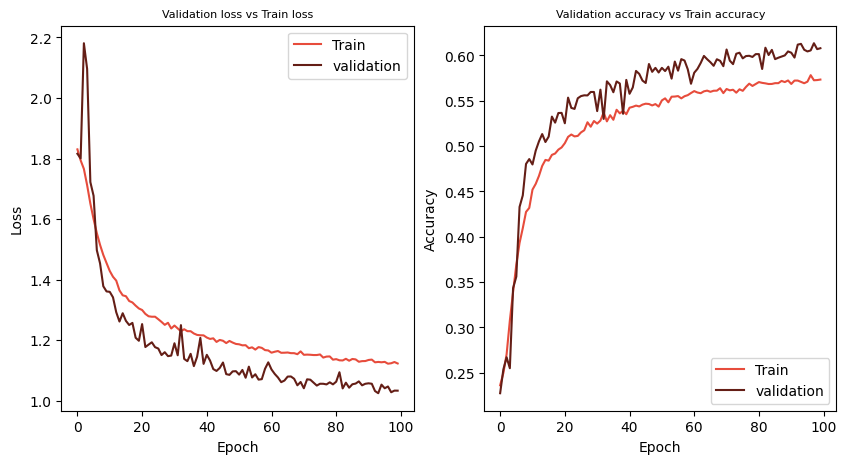

169/169 [==============================] - 24s 137ms/step


In [9]:
from keras.metrics import Accuracy, CategoricalCrossentropy 

loss = CategoricalCrossentropy()
acc = Accuracy()

optim = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
loss_fn = 'CategoricalCrossentropy'

predictions = CNN_Model(train_data, val_data, test_data, optim, loss_fn, 100, data_augmentation = True)


In [44]:
# Predictions  made by the model

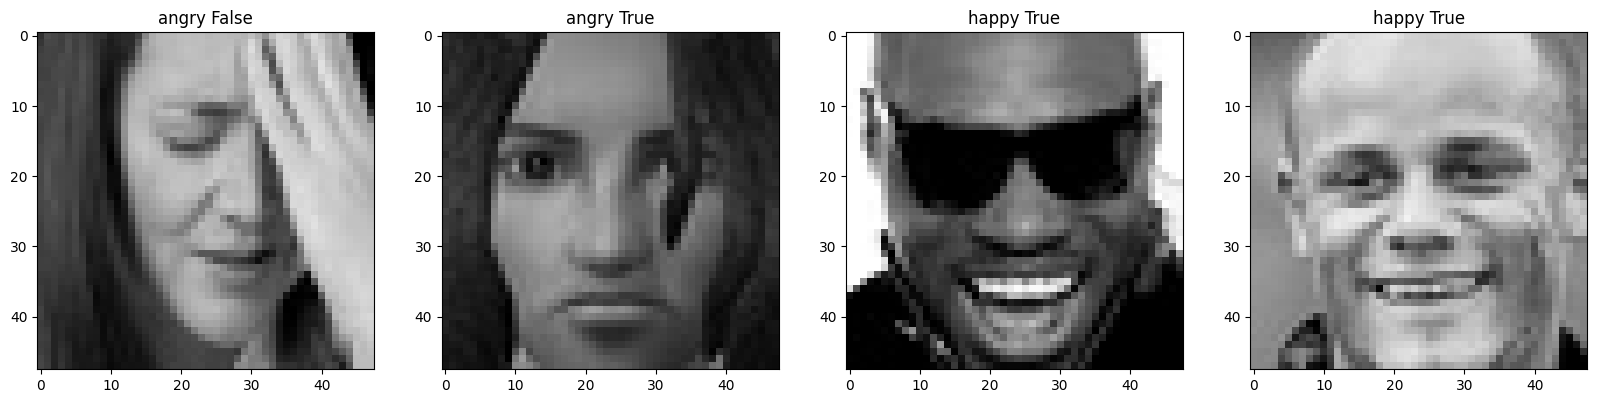

In [84]:

l = np.random.randint(len(test_y), size = 4) 
fig, ax = plt.subplots(nrows = 1,ncols = 4, figsize = (20,20))

for id in range(4):
  i = l[id]
  if predictions[i] == test_y[i]:
      c = " True"
  else: 
      c = " False"
  ax[id].imshow(test_x[i].astype(np.int32))
  ax[id].title.set_text(categories[predictions[i]] + c)
